In [2]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
train = pd.read_csv('~/work/PresidentialTweets/tweets_train.csv')
test = pd.read_csv('~/work/PresidentialTweets/tweets_test.csv')

# Analizing data

We will start with basic data profiling to so where were at.

First test and train:

In [4]:
print ("Dimension of train data {}".format(train.shape))
print ("Dimension of test data {}".format(test.shape))
print ("Basic statistical description:")
train.describe()

Dimension of train data (3999, 9)
Dimension of test data (2349, 11)
Basic statistical description:


,id,retweet_count,favorite_count
count,3.999000e+03,3999.000000,3999.000000
mean,7.594926e+17,4964.529632,12911.969742
std,1.278198e+16,10017.445651,18009.926718
min,7.350000e+17,123.000000,415.000000
25%,7.500000e+17,1409.000000,3644.000000
50%,7.580000e+17,2980.000000,7537.000000
75%,7.700000e+17,6213.500000,17551.500000
max,7.810000e+17,490180.000000,660384.000000


In [61]:
test.describe()

,id,handle,retweet_count,favorite_count
count,2.349000e+03,0.0,2349.000000,2349.000000
mean,7.108067e+17,NaN,3454.904640,9569.874415
std,1.498040e+16,NaN,3174.856432,7374.142302
min,6.840000e+17,NaN,169.000000,307.000000
25%,6.980000e+17,NaN,1538.000000,4508.000000
50%,7.100000e+17,NaN,2682.000000,7850.000000
75%,7.250000e+17,NaN,4473.000000,12944.000000
max,7.340000e+17,NaN,82653.000000,115107.000000


We can see there are almost two times more samples in train and so when were checkig distributions we need to take this into account.
Also we should take into account that althou retweet and favorite count have the same median the top 75% already shows bias which might influence in favour of one candidate and may yield better results if we have a better prior there.

Now some comparisons between data on trump vs hillary:

In [86]:
hilary = train.loc[train.handle == 'HillaryClinton']
hilary.describe()

,id,retweet_count,favorite_count
count,2.724000e+03,2724.000000,2724.000000
mean,7.601413e+17,3264.672907,7379.947137
std,1.256154e+16,10518.057451,15833.686327
min,7.350000e+17,123.000000,415.000000
25%,7.510000e+17,1119.000000,2846.500000
50%,7.590000e+17,1880.000000,4746.000000
75%,7.710000e+17,3330.250000,7941.750000
max,7.810000e+17,490180.000000,660384.000000


In [87]:
trump = train.loc[train.handle != 'HillaryClinton']
trump.describe()

,id,retweet_count,favorite_count
count,1.275000e+03,1275.000000,1275.000000
mean,7.581067e+17,8596.223529,24730.973333
std,1.313872e+16,7686.186621,16637.305561
min,7.350000e+17,1165.000000,5166.000000
25%,7.470000e+17,4834.500000,14838.000000
50%,7.580000e+17,7159.000000,21540.000000
75%,7.690000e+17,10215.500000,29469.000000
max,7.810000e+17,167274.000000,294162.000000


first thing to notice is that trump has about half of the tweets and that should be taken into account in the analasys. Also looking at the favorite count we see trump is a clear leader and the test data shouldn'e worry us as even though the test tweets were less popular the above 75 percent will not be problamatic as in both places they are probably trump and the destribution is the same sort of. in retweet count it doesn't affect us because of the same reasons.

#### Looking at the attributes:

In [13]:
test.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,is_quote_status,lang,retweet_count,favorite_count
0,7.340000e+17,NaN,#MichaelBrown would have been 20 years old tod...,True,LSD_Esq,2016-05-20T18:07:08,NaN,False,en,594,1096
1,7.340000e+17,NaN,"Congratulations on becoming a U.S. citizen, Al...",False,NaN,2016-05-20T17:24:12,NaN,False,en,1701,4239
2,7.340000e+17,NaN,We need a president who will unite leaders aro...,False,NaN,2016-05-20T17:12:52,NaN,False,en,1817,3577
3,7.340000e+17,NaN,"Dear Congress,\n\nLet's get this done.\n\nThan...",False,NaN,2016-05-20T16:21:13,NaN,False,en,2530,6012
4,7.340000e+17,NaN,Failing @NYTimes will always take a good story...,False,NaN,2016-05-20T16:11:21,NaN,False,en,3750,12372


In [14]:
test.tail()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,is_quote_status,lang,retweet_count,favorite_count
2344,6.840000e+17,NaN,"""@lilredfrmkokomo: @realDonaldTrump My Faceboo...",False,NaN,2016-01-05T03:47:14,NaN,False,en,1110,4024
2345,6.840000e+17,NaN,"""@marybnall01: @realDonaldTrump watched lowell...",False,NaN,2016-01-05T03:44:17,NaN,False,en,855,3181
2346,6.840000e+17,NaN,"""@ghosthunter_lol: Iowa key endorsement for @r...",False,NaN,2016-01-05T03:42:10,NaN,False,en,2315,5992
2347,6.840000e+17,NaN,"""@iLoveiDevices: @EdwinRo47796972 @happyjack22...",False,NaN,2016-01-05T03:39:11,NaN,False,en,1054,3258
2348,6.840000e+17,NaN,"""@SalRiccobono: @realDonaldTrump @troyconway D...",False,NaN,2016-01-05T03:36:53,NaN,False,en,748,2658


In [15]:
hilary.head()

,id,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
0,7.810000e+17,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,en,218,651
1,7.810000e+17,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,en,2445,5308
2,7.810000e+17,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,en,7834,27234
3,7.810000e+17,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,en,916,2542
4,7.810000e+17,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,en,859,2882


In [16]:
hilary.tail()

,id,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
3984,7.360000e+17,HillaryClinton,We’re stronger together. When we embrace immig...,False,NaN,2016-05-25T18:02:01,en,1353,3392
3985,7.360000e+17,HillaryClinton,Donald Trump has spent his career looking to t...,False,NaN,2016-05-25T15:58:25,en,971,1732
3986,7.350000e+17,HillaryClinton,Trump bet against American families in the hou...,True,TheBriefing2016,2016-05-25T15:17:32,en,899,1091
3987,7.350000e+17,HillaryClinton,Mientras 5 millones de personas perdían sus ho...,False,NaN,2016-05-25T14:24:10,es,801,962
3990,7.350000e+17,HillaryClinton,Millions of families saw their life savings de...,False,NaN,2016-05-25T12:57:16,en,1987,2894


In [17]:
trump.head()

,id,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
5,7.810000e+17,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False,NaN,2016-09-27T22:13:24,en,2181,6172
8,7.810000e+17,realDonaldTrump,"Once again, we will have a government of, by a...",False,NaN,2016-09-27T21:08:22,en,4132,11239
11,7.810000e+17,realDonaldTrump,"On National #VoterRegistrationDay, make sure y...",True,GOP,2016-09-27T20:31:14,en,2953,6963
12,7.810000e+17,realDonaldTrump,Hillary Clinton's Campaign Continues To Make F...,False,NaN,2016-09-27T20:14:33,en,3833,9840
13,7.810000e+17,realDonaldTrump,"'CNBC, Time magazine online polls say Donald T...",False,NaN,2016-09-27T20:06:25,en,4236,10948


In [18]:
trump.tail()

,id,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
3994,7.350000e+17,realDonaldTrump,"""@buiIdthewall: @realDonaldTrump high energy!""",False,NaN,2016-05-25T05:45:19,en,1984,8121
3995,7.350000e+17,realDonaldTrump,"""@PiperSul: Great speech tonight Mr.Trump! Goo...",False,NaN,2016-05-25T05:45:11,en,1827,7922
3996,7.350000e+17,realDonaldTrump,"""@DeepakS76435750: @realDonaldTrump congratula...",False,NaN,2016-05-25T05:42:59,en,1669,6868
3997,7.350000e+17,realDonaldTrump,"""@oasisupernova: @realDonaldTrump UP TO 8.4 MI...",False,NaN,2016-05-25T05:42:49,en,2684,9643
3998,7.350000e+17,realDonaldTrump,"""@jknatter: @realDonaldTrump #TrumpTrain""",False,NaN,2016-05-25T05:41:38,und,1165,5166


## Charts
Let us see if we can learn something from special charecters.
We normalised the counts so the graphs will match if the distributions match.

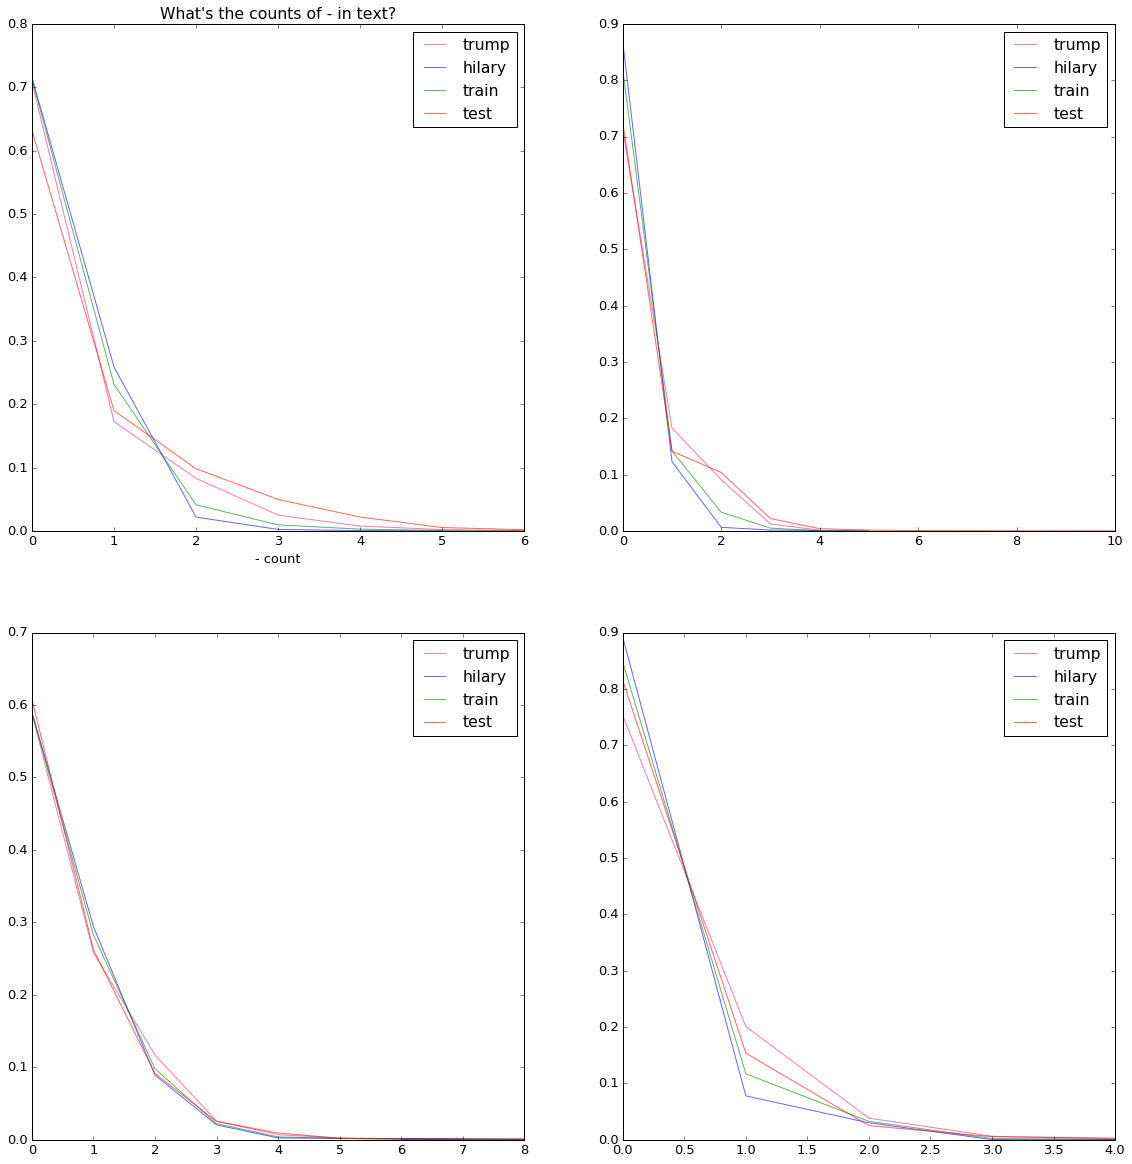

In [59]:
plt.rc('font', size=13)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

def get_special_chars(df):
    res = pd.DataFrame()
    res.reindex(df.index)
    res['@count'] = df['text'].apply(lambda row: row.count('@'))
    res['#count'] = df['text'].apply(lambda row: row.count('#'))
    res['.count'] = df['text'].apply(lambda row: row.count('.'))
    res[',count'] = df['text'].apply(lambda row: row.count(','))
    res['-count'] = df['text'].apply(lambda row: row.count('-'))
    return res

counted_trump = get_special_chars(trump)
counted_hilary = get_special_chars(hilary)
counted_test = get_special_chars(test)
counted_train = get_special_chars(train)

ax1 = plt.subplot2grid((2,3), (0,0))
# since we are counting values it makes sense to regularize the counts
(counted_trump['@count'].value_counts()  / counted_trump.shape[0]).plot(kind='line', color='#FA2379', label='trump', alpha=alpha)
(counted_hilary['@count'].value_counts()  / counted_hilary.shape[0]).plot(kind='line', label='hilary', alpha=alpha)
(counted_train['@count'].value_counts() / counted_train.shape[0]).plot(kind='line', label='train', alpha=alpha)
(counted_test['@count'].value_counts() / counted_test.shape[0]).plot(kind='line', label='test', alpha=alpha)
ax1.set_xlabel('@ count')
ax1.set_title("What's the counts of @ in text?" )
plt.legend(loc='best')

ax2 = plt.subplot2grid((2,3), (0,1))
# since we are counting values it makes sense to regularize the counts
(counted_trump['#count'].value_counts()  / counted_trump.shape[0]).plot(kind='line', color='#FA2379', label='trump', alpha=alpha)
(counted_hilary['#count'].value_counts()  / counted_hilary.shape[0]).plot(kind='line', label='hilary', alpha=alpha)
(counted_train['#count'].value_counts() / counted_train.shape[0]).plot(kind='line', label='train', alpha=alpha)
(counted_test['#count'].value_counts() / counted_test.shape[0]).plot(kind='line', label='test', alpha=alpha)
ax1.set_xlabel('# count')
ax1.set_title("What's the counts of # in text?" )
plt.legend(loc='best')

ax4 = plt.subplot2grid((2,3), (1,0))
# since we are counting values it makes sense to regularize the counts
(counted_trump[',count'].value_counts()  / counted_trump.shape[0]).plot(kind='line', color='#FA2379', label='trump', alpha=alpha)
(counted_hilary[',count'].value_counts()  / counted_hilary.shape[0]).plot(kind='line', label='hilary', alpha=alpha)
(counted_train[',count'].value_counts() / counted_train.shape[0]).plot(kind='line', label='train', alpha=alpha)
(counted_test[',count'].value_counts() / counted_test.shape[0]).plot(kind='line', label='test', alpha=alpha)
ax1.set_xlabel(', count')
ax1.set_title("What's the counts of , in text?" )
plt.legend(loc='best')

ax5 = plt.subplot2grid((2,3), (1,1))
# since we are counting values it makes sense to regularize the counts
(counted_trump['-count'].value_counts()  / counted_trump.shape[0]).plot(kind='line', color='#FA2379', label='trump', alpha=alpha)
(counted_hilary['-count'].value_counts()  / counted_hilary.shape[0]).plot(kind='line', label='hilary', alpha=alpha)
(counted_train['-count'].value_counts() / counted_train.shape[0]).plot(kind='line', label='train', alpha=alpha)
(counted_test['-count'].value_counts() / counted_test.shape[0]).plot(kind='line', label='test', alpha=alpha)
ax1.set_xlabel('- count')
ax1.set_title("What's the counts of - in text?" )
plt.legend(loc='best')

seems like trump is alot more likely to use special charecters more then once in a tweet which will probably be a usefull feature.
Here we see a bias in train/test, train is really missing alot of this compared to test which might indicate trump is more common in test or we have a bias. Let's hope for the first.
### Now let us to look at other features
our columns are:

In [60]:
print(" ".join(train.columns))

id handle text is_retweet original_author time lang retweet_count favorite_count


So it seems logical to look at languages, repeating authors and times. maybe also find if there is a repeating original auther.
Repeating authors are only interesting if they are both in train and test:

In [66]:
def get_all_repeating_original(df):
    counts = df['original_author'].value_counts()
    return counts[counts > 3]
    
(get_all_repeating_original(train) + get_all_repeating_original(test)).dropna()


HFA                55.0
TheBriefing2016    77.0
Name: original_author, dtype: float64

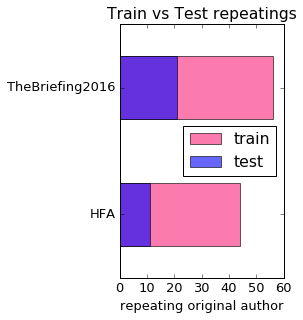

In [68]:
plt.rc('font', size=13)
fig = plt.figure(figsize=(10, 10))
alpha = 0.6

ax1 = plt.subplot2grid((2,3), (0,0))
# since we are counting values it makes sense to regularize the counts
repeating_train = (get_all_repeating_original(train) + get_all_repeating_original(test) - get_all_repeating_original(test)).dropna()
repeating_test = (get_all_repeating_original(train) + get_all_repeating_original(test) - get_all_repeating_original(train)).dropna()
repeating_train.plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
repeating_test.plot(kind='barh', label='test', alpha=alpha)
ax1.set_xlabel('repeating original author')
ax1.set_title("Train vs Test repeatings" )
plt.legend(loc='best')

Lets test trump vs hilary with these to see what we can learn

In [73]:
print(get_all_repeating_original(trump) - get_all_repeating_original(train))
print(get_all_repeating_original(hilary) - get_all_repeating_original(train))

BernieSanders      NaN
ChelseaClinton     NaN
DRUDGE_REPORT      0.0
DanScavino         0.0
HFA                NaN
Hillary_esp        NaN
HillaryforPA       NaN
HillaryforVA       NaN
IvankaTrump        0.0
JoeBiden           NaN
Jorge_Silva        NaN
POTUS              NaN
TeamTrump          0.0
TheBriefing2016    NaN
WhiteHouse         NaN
billclinton        NaN
dominiclowell      NaN
elizabethforma     NaN
johnpodesta        NaN
lorellapraeli      NaN
mayaharris_        NaN
mikereedschmidt    NaN
mpshapiro          NaN
repjohnlewis       NaN
rosenbergerlm      NaN
timkaine           NaN
Name: original_author, dtype: float64
BernieSanders      0.0
ChelseaClinton     0.0
DRUDGE_REPORT      NaN
DanScavino         NaN
HFA                0.0
Hillary_esp        0.0
HillaryforPA       0.0
HillaryforVA       0.0
IvankaTrump        NaN
JoeBiden           0.0
Jorge_Silva        0.0
POTUS              0.0
TeamTrump          NaN
TheBriefing2016    0.0
WhiteHouse         0.0
billclinton        

Seeing everything is zero or non we can assume that a repeating original_author will be a very decisive feature for the rwo repeating ones.

Let us look at languages:

In [79]:
lang_train = train['lang'].value_counts()
lang_test = test['lang'].value_counts()
print("Showing training value counts")
print(lang_train)
print("")
print("Showing test value counts")
print(lang_test)

Showing training value counts
en     3890
es       68
und      40
fr        1
Name: lang, dtype: int64

Showing test value counts
en     2265
und      42
es       34
da        3
tl        2
et        1
fr        1
fi        1
Name: lang, dtype: int64


In [80]:
lang_trump = trump['lang'].value_counts()
lang_hilary = hilary['lang'].value_counts()
print("Showing trump value counts")
print(lang_trump)
print("")
print("Showing hilary value counts")
print(lang_hilary)

Showing trump value counts
en     1241
und      34
Name: lang, dtype: int64

Showing hilary value counts
en     2649
es       68
und       6
fr        1
Name: lang, dtype: int64


as both use different languages we will want a strong prior here to get over the bad distribution (missing values) of languages.

Now taking a look at time. time is like a float or a vary large range integer and so we will want to get a smaller range so it'll make sense.

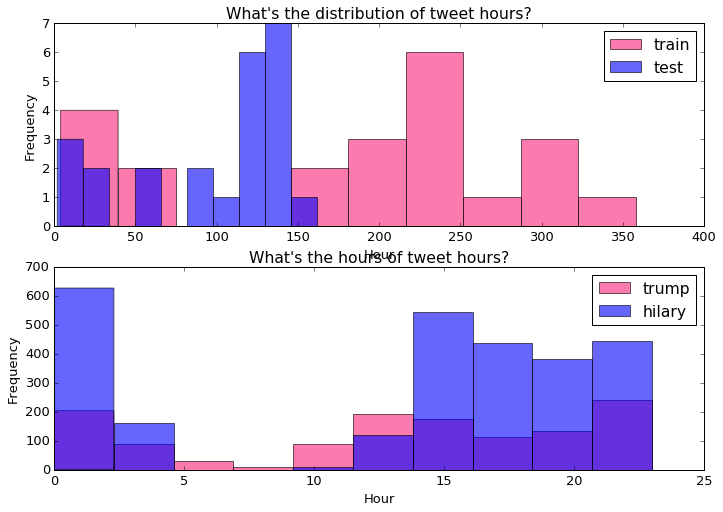

In [88]:
import datetime
def their_time_to_p(time_s):
    return datetime.datetime.strptime(time_s, '%Y-%m-%dT%H:%M:%S')


fixed_train = train.copy(False)
fixed_test = test.copy(False)
fixed_train['time'] = train['time'].map(lambda time_s: their_time_to_p(time_s).hour)
fixed_test['time'] = test['time'].map(lambda time_s: their_time_to_p(time_s).hour)

plt.rc('font', size=13)
fig = plt.figure(figsize=(18, 8))
alpha = 0.6

ax1 = plt.subplot2grid((2,3), (0,0), colspan=2)
fixed_train['time'].value_counts().plot(kind='hist', color='#FA2379', label='train', alpha=alpha)
fixed_test['time'].value_counts().plot(kind='hist', label='test', alpha=alpha)
ax1.set_xlabel('Hour')
ax1.set_title("What's the distribution of tweet hours?" )
plt.legend(loc='best')

fixed_trump = trump.copy(False)
fixed_hilary = hilary.copy(False)

fixed_trump['time'] = trump['time'].map(lambda time_s: their_time_to_p(time_s).hour)
fixed_hilary['time'] = hilary['time'].map(lambda time_s: their_time_to_p(time_s).hour)

ax2 = plt.subplot2grid((2,3), (1,0), colspan=2)
fixed_trump['time'].plot(kind='hist', color='#FA2379', label='trump', alpha=alpha)
fixed_hilary['time'].plot(kind='hist', label='hilary', alpha=alpha)
ax2.set_xlabel('Hour')
ax2.set_title("What's the hours of tweet hours?" )
plt.legend(loc='best')

Seeing this we will have a huge bias towards trump. Really huge. It might be smart to ignore this or use a huge prior.